# Introduction

Voici un petit exercice que je me suis posé pour utiliser Pandas et MatPlotLib pour examiner un dataset. J'ai décidé d'utiliser un des [datasets accessibles au public](https://console.cloud.google.com/marketplace/browse?filter=solution-type:dataset&_ga=2.185442281.1354786271.1650374633-641433170.1650372378&_gac=1.161752654.1650374951.CjwKCAjwu_mSBhAYEiwA5BBmfw7pY7JwSHMay4k9ykRpRvWEcBkjgbx7OCuJTlZ6LHOHYJEhxmk7jBoCXzUQAvD_BwE) de Google - j'ai choisi celui des [Objectifs de Développement Durable des Nations Unies](https://console.cloud.google.com/marketplace/product/un-statistics-division/un-sdgs) avec l'idée d'essayer d'extraire une perspective intéressante.

Il s'est avéré que c'était une bonne formation pour l'exploration des données, principalement en utilisant Pandas, et l'expérience a renforcé le message omniprésent que la plupart du boulot de data science consiste en l'exploration, le nettoyage et la structuration des données avant le début de l'analyse.

# Résultats

L'objectif de cet exercice était principalement de s'entraîner à utiliser des techniques, mais il y avait quand même un sens. La question globale que j'ai fini par examiner était "Est-ce qu'il existe une corrélation entre la puissance économique d'un pays et la réussite de son système d'éducation?". Pour avoir une réponse (très approximative) j'ai comparé compétence de lecture et compétence de mathématiques (selon les définitions des Nations Unies) avec PIB par habitant. Voilà les résultats...

<img src="images/result1a.png" width="100%"/>

<img src="images/result1b.png" width="100%"/>

Donc la réponse à la question "Est-ce qu'il existe une corrélation entre la puissance économique d'un pays et la réussite de son système d'éducation?" a l'air d'être "Oui". En regardant les coefficients de corrélation de rang Spearman, on a tendance à voir une corrélation "forte" selon [ce document](https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf) (i.e., entre 0.60 - 0.79).

Pourtant, bien que les pays plus riches aient tendance à avoir les meilleurs résultats, il y a plusieurs exceptions, et peut-être plus intéressant encore, il y a beaucoup de pays pauvres avec de bons résultats.

Les résultats par région sont affichés ci-dessous. Pas beaucoup plus à constater sauf peut-être la performance forte de l'Asie en Maths pendant les premières années de l'éducation malgré un PIB par habitant relativement bas. (Les coefficients de Spearman ne sont pas fiables à cause des données insuffisantes.)

<img src="images/result2.png" width="100%"/>

Voici maintenant la partie plus intéressante (au moins pour moi) - le reste de ce notebook montre comment produire ces diagrammes...

# Le Dataset sur BigQuery

## Accéder le dataset

Pour accéder aux datasets publics de BigQuery il faut d'abord un compte de Google Cloud Console et ensuite il faut créer un nouveau projet (les détails [ici](https://cloud.google.com/bigquery/docs/quickstarts/query-public-dataset-console)). Ensuite on peut chercher le dataset en utilisant Explorer.

<img src="images/BigQuery-Explorer.png" width="300"/>

## Examiner le dataset

J'ai décidé de travailler avec un dataset assez petit parce que, en utilisant BigQuery:
- Pour les requêtes il y a une limite de 1TB par mois sans payer
- On peut télécharger des fichiers csv des résultats d'une requête avec une limite de 10MB par fichier / requête. (On peut stocker les fichiers plus grands dans Google Cloud Storage mais je voulais travailler directement sur mon ordi.)

### Structure et taille

Pour commençer, le schéma du tableau nous renseigne sur les types et les contenus des colonnes (l'image çi-dessous montre un extrait du schéma - cliquer pour agrandir)

<a href="images/un-sdg-table-schema.png" target="_blank"><img src="images/un-sdg-table-schema-extract.png" width=600 /></a>

On peut également visualiser les contenus du tableau pour voir les genres de données qu'on a.

<img src="images/un-sdg-table-preview.png" />

On peut voir immédiatement que les colonnes d'objectif, de cible, d'indicateur et de valuer sont les colonnes essentielles qui correspondent à la structure affichée sur la [page d'accueil de UN SDG](https://sdgs.un.org/fr/goals). Par exemple, en prenant la première ligne du tableau, on peut voir comment elle correspond à l'objectif 8, la cible 8.5, et l'indicateur 8.5.1 comme indiqué çi-dessous (copié de la sous-section Targets and Indicators de la [Goal 8 page](https://sdgs.un.org/goals/goal8) (disponible en anglais seulement)).

<img src="images/Target-8-5.png" />

En faisant défiler vers la droite on peut voir qu'il y a plusieurs colonnes où il est possible qu'elles contiennent beaucoup de valeurs `null`. À étudier...

<img src="images/un-sdg-table-preview-nulls.png" />

Et en dessous de la fenêtre de visualisation on peut voir que le tableau contient un peu plus de 1 million lignes.

<img src="images/un-sdg-table-schema-rows.png" />

1 million de lignes n'est pas énorme. Sélectionner le tableau entier paraît possible en utilisant `SELECT * FROM bigquery-public-data.un_sdg.indicators` car BigQuery affiche combien du quota de requête sera utilisé, et cette fois-çi c'est assez petit. Mais malheureusement, quand on execute la requête et ensuite on télécharge les résultats le fichier est limité à environ 12,000 des 1 million lignes pour respecter la limite de 10MB. Donc ça ne marche pas.

<img src="images/un-sdg-select-whole-table.png" />

Bon - peut-étre qu'il vaut mieux choisir un seul objectif et extraire ces données. C'est le moment d'utiliser un peu de SQL pour examiner ce qu'on a, et aussi pour comprendre ce qui est accessible pratiquement sans manger le quota de requête et sans excéder la limite de taille de fichier à télécharger. La requête çi-dessous me donne le nombre de lignes par objectif:

```
SELECT goal, COUNT(*) AS num_rows
FROM bigquery-public-data.un_sdg.indicators
GROUP BY goal
ORDER BY goal
```

On peut examiner le fichier csv téléchargé des résultats en utilisant pandas. Un moyen pour réduire la quantité des données c'est de focaliser sur une sous-catégorie des objectifs, donc affichons les volumes des données par objectif.

In [1]:
import numpy as np
import pandas as pd

In [2]:
rows_per_goal = pd.read_csv('data/count-rows-per-goal.csv')
total_rows = rows_per_goal['num_rows'].sum()
print(f"Total rows : {total_rows:,}")
rows_per_goal.style.format("{:,}")

Total rows : 1,050,781


,goal,num_rows
0,1,"62,742"
1,2,"38,659"
2,3,"134,617"
3,4,"41,533"
4,5,"21,703"
5,6,"36,062"
6,7,"19,670"
7,8,"270,140"
8,9,"34,880"
9,10,"19,241"


Regardons les valeurs `null` aussi. Si on ne va choisir qu'un seul objectif ou peut-être deux, peut-être que quelques colonnes ne sont pas pertinentes pour certains objectifs. Par conséquent on pourra les exclure. Pour compter toutes les valeurs `null` des colonnes je me servirai d'une requête de la forme ci-dessous:

```
SELECT goal, COUNT(goal) AS num_rows,
SUM(CASE WHEN col1_name IS NULL THEN 1 ELSE 0 END) as col1_name,
SUM(CASE WHEN col2_name IS NULL THEN 1 ELSE 0 END) as col2_name
FROM bigquery-public-data.un_sdg.indicators
GROUP BY goal
ORDER BY goal
```

Donc on a besoin d'une liste des titres des colonnes pour qu'on puisse les inclure dans la requête. Bien sûr on pourrait copier coller du schéma BigQuery et ensuite utiliser Excel pour concaténer, mais pour moi c'est de la tricherie - l'idée c'est de s'entraîner avec Python! À la place on peut utiliser SQL pour extraire les titres des colonnes et ensuite utiliser Pandas / Python pour créer la requête. Voici la requête pour les titres des colonnes:

```
SELECT COLUMN_NAME
FROM `bigquery-public-data`.un_sdg.INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'indicators'
ORDER BY ORDINAL_POSITION
```

...qui nous donne le résultat ci-dessous (en enlevant la colonne goal):

In [3]:
column_names = pd.read_csv('data/un-sdg-column-names.csv')
column_names_list = column_names['COLUMN_NAME'].tolist()
del column_names_list[0]
print(column_names_list)

['target', 'indicator', 'seriescode', 'seriesdescription', 'geoareacode', 'geoareaname', 'timeperiod', 'value', 'time_detail', 'source', 'footnote', 'nature', 'age', 'bounds', 'cities', 'education_level', 'freq', 'hazard_type', 'ihr_capacity', 'level_status', 'location', 'migratory_status', 'mode_of_transportation', 'name_of_international_institution', 'name_of_non_communicable_disease', 'sex', 'tariff_regime_status', 'type_of_mobile_technology', 'type_of_occupation', 'type_of_product', 'type_of_skill', 'type_of_speed', 'units']


Maintenant on peut créer une chaîne à partir de la liste pour la requête.

In [4]:
sql_col_expressions = list(map(lambda col_name : 'SUM(CASE WHEN ' + col_name + ' IS NULL THEN 1 ELSE 0 END) AS ' + col_name, column_names_list))
sql_col_str = ', '.join(sql_col_expressions)

# Display a truncated extract of the string
print(sql_col_str[0:400] + "...")

SUM(CASE WHEN target IS NULL THEN 1 ELSE 0 END) AS target, SUM(CASE WHEN indicator IS NULL THEN 1 ELSE 0 END) AS indicator, SUM(CASE WHEN seriescode IS NULL THEN 1 ELSE 0 END) AS seriescode, SUM(CASE WHEN seriesdescription IS NULL THEN 1 ELSE 0 END) AS seriesdescription, SUM(CASE WHEN geoareacode IS NULL THEN 1 ELSE 0 END) AS geoareacode, SUM(CASE WHEN geoareaname IS NULL THEN 1 ELSE 0 END) AS geo...


Voici le résultat de la requête.

In [5]:
nulls_per_goal = pd.read_csv('data/un-sdg-non-null entries-by-goal.csv')
nulls_per_goal.style.set_table_styles([

    # Add styles so we can have narrow columns but show the column title in full on hover.
    {'selector': ' .col_heading', 'props': 'max-width: 30px; overflow: hidden'},
    {'selector': '.col_heading:hover', 'props': '; overflow: visible'},
    {'selector': '.col_heading:hover~.col_heading', 'props': '; visibility: hidden'},

], overwrite=False)

,goal,num_rows,target,indicator,seriescode,seriesdescription,geoareacode,geoareaname,timeperiod,value,time_detail,source,footnote,nature,age,bounds,cities,education_level,freq,hazard_type,ihr_capacity,level_status,location,migratory_status,mode_of_transportation,name_of_international_institution,name_of_non_communicable_disease,sex,tariff_regime_status,type_of_mobile_technology,type_of_occupation,type_of_product,type_of_skill,type_of_speed,units
0,1,62742,0,0,0,0,0,0,0,0,9353,0,10606,0,54372,62742,62742,62742,62742,30332,62742,62742,62010,62742,62742,62742,62742,53389,62742,62742,62742,62742,62742,62742,0
1,2,38659,0,0,0,0,0,0,0,0,0,0,5212,0,34958,34958,38659,38659,38659,38659,38659,38659,38659,38659,38659,38659,38659,38659,38659,38659,38659,38492,38659,38659,0
2,3,134617,0,0,0,0,0,0,0,0,2668,0,114972,0,85929,111544,134617,134617,131757,134617,119661,134617,134617,134617,134617,134617,121957,65508,134617,134617,130470,134617,134617,134617,0
3,4,41533,0,0,0,0,0,0,0,0,36695,0,39627,0,41397,41533,41533,10857,41533,41533,41533,41533,41533,41533,41533,41533,41533,18790,41533,41533,41533,41533,39903,41533,0
4,5,21703,0,0,0,0,0,0,0,0,2076,0,4740,0,15136,21703,21703,21703,21703,21703,21703,21703,16063,21703,21703,21703,21703,442,21703,21703,21703,21703,21703,21703,0
5,6,36062,0,0,0,0,0,0,0,0,0,0,31874,0,36062,36062,36062,36062,18186,36062,36062,35051,17499,36062,36062,36062,36062,36062,36062,36062,36062,36062,36062,36062,0
6,7,19670,0,0,0,0,0,0,0,0,1080,0,19670,0,19670,19670,19670,19670,19670,19670,19670,19670,8534,19670,19670,19670,19670,19670,19670,19670,19670,19670,19670,19670,0
7,8,270140,0,0,0,0,0,0,0,0,10413,0,238315,0,244885,270140,270140,270140,270140,270140,270140,270140,270140,266993,270140,270140,270140,241422,270140,270140,266067,45679,270140,270140,0
8,9,34880,0,0,0,0,0,0,0,0,1,0,14860,0,34880,34880,34880,34880,34880,34880,34880,34880,34880,34880,33684,34880,34880,34880,34880,29402,34880,34880,34880,34880,0
9,10,19241,0,0,0,0,0,0,0,0,750,0,14429,0,19241,19241,19241,19241,19241,19241,19241,19241,19241,19241,19241,5091,19241,19241,19241,19241,19241,19157,19241,19241,0


On aura besoin de convertir ces chiffres en pourcentage pour les rendre utiles, mais avant ça ajoutons la liste des objectifs UN SDG pour qu'on sache de quoi ils parlent. J'ai copié la liste de [Wikipedia](https://en.wikipedia.org/wiki/Sustainable_Development_Goals) et je l'ai collée dans un fichier texte. 

In [6]:
with open("data/un-sdg-goals-list.txt", "r") as f:
    goals_list = f.read().splitlines()
print(goals_list)

['No Poverty', 'Zero Hunger', 'Good Health and Well-being', 'Quality Education', 'Gender Equality', 'Clean Water and Sanitation', 'Affordable and Clean Energy', 'Decent Work and Economic Growth', 'Industry, Innovation and Infrastructure', 'Reduced Inequality', 'Sustainable Cities and Communities', 'Responsible Consumption and Production', 'Climate Action', 'Life Below Water', 'Life On Land', 'Peace', 'Justice', 'Strong Institutions', 'Partnerships for the Goals']


Maintenant on peut convertir en pourcentage et ajouter les objectifs. Le tableau montre les pourcentage des valeurs `null`, et avec un peu de mise en forme, on peut voir facilement où il y a des trous et par conséquent des colonnes à exclure. (Plus le vert est foncé moins il y a des valeurs null.)

In [7]:
# Calculate percent of nulls per row
nulls_per_goal_percentages = nulls_per_goal.iloc[:,2:].divide(
    nulls_per_goal['num_rows'], axis=0
)

# Add in the goals and goal title columns
nulls_per_goal_percentages.insert(0, 'goal', nulls_per_goal['goal'])
nulls_per_goal_percentages.insert(1, 'goal_title', pd.Series(goals_list))

# Define a dataframe to apply 'nowrap' class to all cells in the goal_title column
classes = pd.DataFrame(
    [['nowrap']],
    index=nulls_per_goal_percentages.index,
    columns=['goal_title']
)

idx = pd.IndexSlice
display(
    nulls_per_goal_percentages.style
 
    # Set the background gradient - Dark green for 0 nulls, light green for 100% nulls.
    .background_gradient(cmap='Greens_r', vmin=0, vmax=1, subset=idx[:, idx['target':]])

    # Hide the zeros and format other numbers as percentages.
    .format(lambda v: "" if v==0 else f"{v:.1%}", subset=idx[:, idx['target':]])

    # Apply the classes to the table cells.
    .set_td_classes(classes)
    
    .set_table_styles([
        
        # Add internal styles to nowrap class to prevent goal titles wrapping.
        {'selector': '.nowrap', 'props': 'min-width: 100px;'},
        
        # Add styles so we can have narrow columns but show the column title in full on hover.
        {'selector': '.col_heading', 'props': 'max-width: 30px; overflow: hidden'},
        {'selector': '.col_heading:hover', 'props': '; overflow: visible'},
        {'selector': '.col_heading:hover~.col_heading', 'props': '; visibility: hidden'},

    ], overwrite=False)
)

,goal,goal_title,target,indicator,seriescode,seriesdescription,geoareacode,geoareaname,timeperiod,value,time_detail,source,footnote,nature,age,bounds,cities,education_level,freq,hazard_type,ihr_capacity,level_status,location,migratory_status,mode_of_transportation,name_of_international_institution,name_of_non_communicable_disease,sex,tariff_regime_status,type_of_mobile_technology,type_of_occupation,type_of_product,type_of_skill,type_of_speed,units
0,1,No Poverty,,,,,,,,,14.9%,,16.9%,,86.7%,100.0%,100.0%,100.0%,100.0%,48.3%,100.0%,100.0%,98.8%,100.0%,100.0%,100.0%,100.0%,85.1%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,
1,2,Zero Hunger,,,,,,,,,,,13.5%,,90.4%,90.4%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.6%,100.0%,100.0%,
2,3,Good Health and Well-being,,,,,,,,,2.0%,,85.4%,,63.8%,82.9%,100.0%,100.0%,97.9%,100.0%,88.9%,100.0%,100.0%,100.0%,100.0%,100.0%,90.6%,48.7%,100.0%,100.0%,96.9%,100.0%,100.0%,100.0%,
3,4,Quality Education,,,,,,,,,88.4%,,95.4%,,99.7%,100.0%,100.0%,26.1%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,45.2%,100.0%,100.0%,100.0%,100.0%,96.1%,100.0%,
4,5,Gender Equality,,,,,,,,,9.6%,,21.8%,,69.7%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,74.0%,100.0%,100.0%,100.0%,100.0%,2.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,
5,6,Clean Water and Sanitation,,,,,,,,,,,88.4%,,100.0%,100.0%,100.0%,100.0%,50.4%,100.0%,100.0%,97.2%,48.5%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,
6,7,Affordable and Clean Energy,,,,,,,,,5.5%,,100.0%,,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,43.4%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,
7,8,Decent Work and Economic Growth,,,,,,,,,3.9%,,88.2%,,90.7%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,98.8%,100.0%,100.0%,100.0%,89.4%,100.0%,100.0%,98.5%,16.9%,100.0%,100.0%,
8,9,"Industry, Innovation and Infrastructure",,,,,,,,,0.0%,,42.6%,,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,96.6%,100.0%,100.0%,100.0%,100.0%,84.3%,100.0%,100.0%,100.0%,100.0%,
9,10,Reduced Inequality,,,,,,,,,3.9%,,75.0%,,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,26.5%,100.0%,100.0%,100.0%,100.0%,100.0%,99.6%,100.0%,100.0%,


On dirait que plusieurs colonnes ne sont pertinentes que pour certains objectifs. On devrait probablement approfondir dans les indicateurs pour comprendre ce que les données représentent et pour identifier les colonnes qui sont pertinentes.

In [8]:
nulls_per_indicator = pd.read_csv('data/un-sdg-non-null-entries-by-indicator.csv')

# Add in the goal titles and reposition
nulls_per_indicator = nulls_per_indicator.merge(
    nulls_per_goal_percentages.loc[:, 'goal':'goal_title'],
    left_on='goal', right_on='goal',
)
nulls_per_indicator.insert(1, 'goal_title', nulls_per_indicator.pop('goal_title'))

total_rows = nulls_per_indicator['goal'].count()
print(f"Total number of indicators : {total_rows:,}")

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(nulls_per_indicator.head())

Total number of indicators : 374


,goal,goal_title,target,indicator,seriescode,seriesdescription,num_rows,geoareacode,geoareaname,timeperiod,...,name_of_international_institution,name_of_non_communicable_disease,sex,tariff_regime_status,type_of_mobile_technology,type_of_occupation,type_of_product,type_of_skill,type_of_speed,units
0,1,No Poverty,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international poverty line (%),1345,0,0,0,...,1345,1345,1345,1345,1345,1345,1345,1345,1345,0
1,1,No Poverty,1.1,1.1.1,SI_POV_EMP1,"Employed population below international poverty line, by sex and age (%)",8370,0,0,0,...,8370,8370,0,8370,8370,8370,8370,8370,8370,0
2,1,No Poverty,1.2,1.2.1,SI_POV_NAHC,Proportion of population living below the national poverty line (%),732,0,0,0,...,732,732,732,732,732,732,732,732,732,0
3,1,No Poverty,1.3,1.3.1,SI_COV_BENFTS,Proportion of population covered by at least one social protection benefit (%),105,0,0,0,...,105,105,0,105,105,105,105,105,105,0
4,1,No Poverty,1.3,1.3.1,SI_COV_CHLD,Proportion of children/households receiving child/family cash benefit (%),94,0,0,0,...,94,94,0,94,94,94,94,94,94,0


Une longue liste - 374 indicateurs! (On peut tous les voir en supprimant `.head()` de la dernière ligne de la cellule ci-dessus. Je fais ceci partout dans le notebook pour qu'une version pdf ne soit pas énorme...)

Un examen rapide et j'ai décidé qu'il pourrait être intéressant d'interroger *No Poverty*, *Quality Education* et *Decent Work and Economic Growth* pour voir s'il y avait des corrélations.

In [9]:
selected_indicators = [1, 4, 8]
nulls_per_selected_indicators = nulls_per_indicator.loc[nulls_per_indicator['goal'].isin(selected_indicators)]

descriptions_selected_indicators = nulls_per_selected_indicators[['goal', 'goal_title', 'seriescode', 'seriesdescription']]
with pd.option_context('display.max_colwidth', None):
    display(descriptions_selected_indicators.head())

,goal,goal_title,seriescode,seriesdescription
0,1,No Poverty,SI_POV_DAY1,Proportion of population below international poverty line (%)
1,1,No Poverty,SI_POV_EMP1,"Employed population below international poverty line, by sex and age (%)"
2,1,No Poverty,SI_POV_NAHC,Proportion of population living below the national poverty line (%)
3,1,No Poverty,SI_COV_BENFTS,Proportion of population covered by at least one social protection benefit (%)
4,1,No Poverty,SI_COV_CHLD,Proportion of children/households receiving child/family cash benefit (%)


En examinant les descriptions, au début j'ai choisi 7 indicateurs que j'ai estimé intéressants - avec l'idée de voir s'il y avait une corrélation entre les étudiants qui réussissent et la puissance économique.

In [10]:
selected_codes = [
    'SI_POV_DAY1',
    'SE_MAT_PROF',
    'SE_REA_PROF',
    'SE_ADT_EDUCTRN',
    'SE_ADT_FUNS',
    'SE_TRA_GRDL',
    'NY_GDP_PCAP',
    'SL_TLF_UEM',
]
nulls_per_selected_codes = nulls_per_selected_indicators[nulls_per_selected_indicators['seriescode'].isin(selected_codes)]
with pd.option_context('display.max_colwidth', None):
    display(nulls_per_selected_codes.loc[:, 'goal':'num_rows'])

,goal,goal_title,target,indicator,seriescode,seriesdescription,num_rows
0,1,No Poverty,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international poverty line (%),1345
115,4,Quality Education,4.1,4.1.1,SE_MAT_PROF,"Minimum proficiency in mathematics, by education level and sex (%)",2172
116,4,Quality Education,4.1,4.1.1,SE_REA_PROF,"Minimum proficiency in reading, by education level and sex (%)",1698
119,4,Quality Education,4.3,4.3.1,SE_ADT_EDUCTRN,"Participation rate in formal and non-formal education and training, by sex (%)",273
138,4,Quality Education,4.6,4.6.1,SE_ADT_FUNS,"Proportion of population achieving at least a fixed level of proficiency in functional skills, by sex, age and type of skill (%)",68
147,4,Quality Education,4.c,4.c.1,SE_TRA_GRDL,"Proportion of teachers who have received at least the minimum organized teacher training (e.g. pedagogical training) pre-service or in-service required for teaching at the relevant level in a given country, by education level (%)",12207
205,8,Decent Work and Economic Growth,8.1,8.1.1,NY_GDP_PCAP,Annual growth rate of real GDP per capita (%),4210
218,8,Decent Work and Economic Growth,8.5,8.5.2,SL_TLF_UEM,"Unemployment rate, by sex and age (%)",16508


## Extraire les données

Enfin! On peut extraire les données. Exécuter la requête dans la forme ci-dessous, en sélectionnant seulement les colonnes et les codes des séries pertinentes, ont produit un fichier de moins de 10MB.

```
SELECT
    seriescode, geoareacode, geoareaname, timeperiod, value, time_detail,
    nature, age, education_level, sex, type_of_skill, units
FROM bigquery-public-data.un_sdg.indicators
WHERE
    seriescode IN (
        'SI_POV_DAY1',
        'SE_MAT_PROF',
        'SE_REA_PROF',
        'SE_ADT_EDUCTRN',
        'SE_ADT_FUNS',
        'SE_TRA_GRDL',
        'NY_GDP_PCAP',
        'SL_TLF_UEM'
    )
```

Voici les premières lignes des données.

In [11]:
all_data = pd.read_csv('data/un-sdg-goals-selected-codes-results.csv')
all_data.head()

,seriescode,geoareacode,geoareaname,timeperiod,value,time_detail,nature,age,education_level,sex,type_of_skill,units
0,SE_ADT_FUNS,250,France,2012,90.83946,NaN,C,16-65,NaN,BOTHSEX,NUME,PERCENT
1,SE_ADT_FUNS,616,Poland,2012,96.05922,NaN,C,16-65,NaN,BOTHSEX,LITE,PERCENT
2,SE_ADT_FUNS,418,Lao People's Democratic Republic,2012,73.78760,NaN,C,15-65,NaN,BOTHSEX,LITE,PERCENT
3,SE_ADT_FUNS,40,Austria,2012,96.53522,NaN,C,16-65,NaN,BOTHSEX,NUME,PERCENT
4,SE_ADT_FUNS,152,Chile,2015,79.63343,NaN,C,16-65,NaN,BOTHSEX,LITE,PERCENT


# Manipuler les données en utilisant Pandas

## Examiner les données

J'ai choisi d'examiner d'abord SE_MAT_PROF et SE_REA_PROF: *Minimum proficiency in mathematics, by education level and sex (%)* et *Minimum proficiency in reading, by education level and sex (%)*. En utilisant `describe()` on dirait que les colonnes d'intérêt (outre `geoareacode`, `geoarename`, `value` and `timeperiod`) sont `education_level` et `sex`, puisque `time_detail`, `age` et `type_of_skill` ne contiennent que des valeurs `null`, et `nature` et `units` n'ont qu'une valeur. 

In [12]:
chart_series_codes = ['SE_MAT_PROF', 'SE_REA_PROF']

for chart_series_code in chart_series_codes:
    print(f"Describing series : {chart_series_code}")
    display(all_data[all_data['seriescode'] == chart_series_code].describe(include='all'))

Describing series : SE_MAT_PROF


,seriescode,geoareacode,geoareaname,timeperiod,value,time_detail,nature,age,education_level,sex,type_of_skill,units
count,2172,2172.000000,2172,2172.000000,2172.000000,0.0,2172,0,2172,2172,0,2172
unique,1,NaN,131,NaN,NaN,NaN,1,0,3,3,0,1
top,SE_MAT_PROF,NaN,"China, Hong Kong Special Administrative Region",NaN,NaN,NaN,C,NaN,LOWSEC,BOTHSEX,NaN,PERCENT
freq,2172,NaN,36,NaN,NaN,NaN,2172,NaN,1395,724,NaN,2172
mean,NaN,444.128453,NaN,2008.790055,69.058890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,242.341232,NaN,4.604399,23.171540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,8.000000,NaN,2000.000000,5.610000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,246.000000,NaN,2006.000000,52.047895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,428.000000,NaN,2009.000000,76.598550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,643.000000,NaN,2012.000000,87.901095,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Describing series : SE_REA_PROF


,seriescode,geoareacode,geoareaname,timeperiod,value,time_detail,nature,age,education_level,sex,type_of_skill,units
count,1698,1698.000000,1698,1698.000000,1698.000000,0.0,1698,0,1698,1698,0,1698
unique,1,NaN,121,NaN,NaN,NaN,1,0,3,3,0,1
top,SE_REA_PROF,NaN,Colombia,NaN,NaN,NaN,C,NaN,LOWSEC,MALE,NaN,PERCENT
freq,1698,NaN,27,NaN,NaN,NaN,1698,NaN,1029,566,NaN,1698
mean,NaN,437.830389,NaN,2008.109541,73.414752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,240.655446,NaN,4.823925,20.409998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,8.000000,NaN,2000.000000,7.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,233.000000,NaN,2006.000000,61.157138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,428.000000,NaN,2009.000000,79.002285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,642.000000,NaN,2012.000000,88.909627,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut utiliser un tableau croisé dynamique pour vérifier qu'on a bien identifié toutes les dimensions par lesquelles on peut grouper `value`:

In [13]:
se_prof_data = all_data[all_data['seriescode'].isin(chart_series_codes)]
se_prof_pivot_table = se_prof_data.pivot_table(
    'value',
    index=['seriescode', 'geoareaname', 'sex'],
    columns=['education_level', 'timeperiod'],
    aggfunc='count'
)
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(se_prof_pivot_table.head(10).style.format("{:.1f}", na_rep=""))

On peut vérifier visuellement que toutes les valeurs dans le tableau soient ou 1.0 ou vide, mais il vaut mieux vérifier par programme. On ne devrait avoir aucune ligne dans le tableau croisé dynamique si on n'extrait que les lignes qui contiennent les valeurs qui ne sont pas égales à 1.0 et NaN.

In [14]:
print("Displaying any rows where values are not 1.0 or NaN")
display(se_prof_pivot_table[se_prof_pivot_table.isin([1.0, np.nan]).all(axis=1) == False])

Displaying any rows where values are not 1.0 or NaN


Empty DataFrame
Columns: [(GRAD23, 2001), (GRAD23, 2003), (GRAD23, 2006), (GRAD23, 2007), (GRAD23, 2011), (GRAD23, 2013), (GRAD23, 2014), (GRAD23, 2015), (LOWSEC, 2000), (LOWSEC, 2003), (LOWSEC, 2006), (LOWSEC, 2007), (LOWSEC, 2009), (LOWSEC, 2011), (LOWSEC, 2012), (LOWSEC, 2015), (PRIMAR, 2000), (PRIMAR, 2001), (PRIMAR, 2003), (PRIMAR, 2006), (PRIMAR, 2007), (PRIMAR, 2011), (PRIMAR, 2013), (PRIMAR, 2014), (PRIMAR, 2015)]
Index: []

[0 rows x 25 columns]

On dirait que, où qu'il y ait des données, il y a des données pour `BOTHSEX`, `FEMALE` et `MALE`. On peut vérifier cela en enlevant le regroupement de `sex`. D'abord une vérification visuelle...

In [15]:
se_prof_pivot_table = se_prof_data.pivot_table(
    'value',
    index=['seriescode', 'geoareaname'],
    columns=['education_level', 'timeperiod'],
    aggfunc='count'
)
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(se_prof_pivot_table.head(10).style.format("{:.1f}", na_rep=""))

Que 3.0 ou vide. Et la vérification par programme le confirme.

In [16]:
print("Displaying any rows where values are not 3.0 or Nan")
display(se_prof_pivot_table[se_prof_pivot_table.isin([3.0, np.nan]).all(axis=1) == False])

Displaying any rows where values are not 3.0 or Nan


Empty DataFrame
Columns: [(GRAD23, 2001), (GRAD23, 2003), (GRAD23, 2006), (GRAD23, 2007), (GRAD23, 2011), (GRAD23, 2013), (GRAD23, 2014), (GRAD23, 2015), (LOWSEC, 2000), (LOWSEC, 2003), (LOWSEC, 2006), (LOWSEC, 2007), (LOWSEC, 2009), (LOWSEC, 2011), (LOWSEC, 2012), (LOWSEC, 2015), (PRIMAR, 2000), (PRIMAR, 2001), (PRIMAR, 2003), (PRIMAR, 2006), (PRIMAR, 2007), (PRIMAR, 2011), (PRIMAR, 2013), (PRIMAR, 2014), (PRIMAR, 2015)]
Index: []

[0 rows x 25 columns]

Puisque les données sont dispersées partout temporellement on aura besoin de décider comment gérer ça. En outre, selon le tableau ci-dessous c'est clair que plusieurs pays n'ont pas des données pour certains niveaux d'éducation, et quelques pays où les données n'existent pas du tout pour une compétence éducative (e.g. Belize - SE_MAT_PROF).

In [17]:
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(
        se_prof_data.pivot_table(
            'value',
            index=['geoareaname'],
            columns=['seriescode','education_level'],
            aggfunc='count',
            fill_value = ""
        ).head(10)
    )

seriescode      SE_MAT_PROF               SE_REA_PROF              
education_level      GRAD23 LOWSEC PRIMAR      GRAD23 LOWSEC PRIMAR
geoareaname                                                        
Albania                       12.0                      12.0       
Algeria                 3.0    6.0                       3.0       
Argentina               3.0   15.0    6.0         6.0   15.0    6.0
Armenia                        9.0    9.0                          
Australia              12.0   18.0                3.0   18.0       
Austria                       18.0    6.0               18.0    6.0
Azerbaijan                     6.0    3.0                6.0    3.0
Bahrain                 6.0   12.0                                 
Belgium                       18.0                      18.0       
Belize                                            3.0

Finalement, on devrait comprendre comment les niveaux d'éducation sont définis. Les descriptions complètes pour tous les indicateurs se trouvent [ici](https://unstats.un.org/sdgs/indicators/Global%20Indicator%20Framework%20after%202022%20refinement_Fre.pdf) sur le site des Nations Unies et là on trouve cette définition de l'indicateur 4.1.1:
>Proportion d’enfants et de jeunes a) en 2e ou 3e année de cycle primaire ; b) en fin de cycle primaire ; c) en fin de premier cycle du secondaire qui maîtrisent au moins les normes d’aptitudes minimales en i) lecture et ii) mathématiques, par sexe

Donc créons des étiquettes plus lisibles dont on se servira plus tard à la place des codes des niveaux d'éducation:

In [18]:
edu_level_labels = {
    'GRAD23' : 'Grade 2/3',
    'PRIMAR' : 'End of primary',
    'LOWSEC' : 'End of lower secondary'
}

## Selectionner les données

D'abord j'ai décidé de simplifier en n'incluant que les données pour les deux sexes combinés. Ça veut dire qu'on perd la dimension `sex` mais on sait qu'on ne perd pas de la couverture par rapport aux autres dimensions grâce à l'analyse ci-dessus qui montre que, où qu'on ait des données, on a les données pour toutes les catégories de `sex`. Donc sélectionnons seulement les données de BOTHSEX et supprimons les colonnes non pertinentes de `time_detail`, `age`, `type_of_skill`, `nature` et `units`.

In [19]:
se_prof_chart_data = (
    se_prof_data[(se_prof_data['sex'] == 'BOTHSEX')]
    .drop(['time_detail', 'age', 'type_of_skill', 'nature', 'units'], axis=1)
)

se_prof_chart_data.pivot_table(
    'value',
    index=['geoareaname'],
    columns=['seriescode', 'education_level'],
    aggfunc='count',
    fill_value = ""
)

seriescode                         SE_MAT_PROF               SE_REA_PROF  \
education_level                         GRAD23 LOWSEC PRIMAR      GRAD23   
geoareaname                                                                
Albania                                           4.0                      
Algeria                                    1.0    2.0                      
Argentina                                  1.0    5.0    2.0         2.0   
Armenia                                           3.0    3.0               
Australia                                  4.0    6.0                1.0   
...                                        ...    ...    ...         ...   
Venezuela (Bolivarian Republic of)                1.0                      
Viet Nam                                          2.0                      
Yemen                                      3.0                             
Zambia                                                   2.0               
Zimbabwe                                                 1.0               

seriescode                                        
education_level                    LOWSEC PRIMAR  
geoareaname                                       
Albania                               4.0         
Algeria                               1.0         
Argentina                             5.0    2.0  
Armenia                                           
Australia                             6.0         
...                                   ...    ...  
Venezuela (Bolivarian Republic of)    1.0         
Viet Nam                              2.0         
Yemen                                             
Zambia                                       2.0  
Zimbabwe                                     1.0  

[132 rows x 6 columns]

Maintenant il faut décider comment gérer les données temporelles. On sait que les données sont dispersées un peu au hasard temporellement comme montré ci-dessous.

In [20]:
total_countries = len(se_prof_chart_data['geoareacode'].unique())

data_time_coverage = (
    se_prof_chart_data.pivot_table(
        'value',
        index=['timeperiod'],
        columns=['seriescode', 'education_level'],
        aggfunc='count',
        margins=True,
        margins_name='Total'
    )
    .style
    .set_caption(f'Number of countries (out of {total_countries}) with data for given year and education level')
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black')]
        },
        {
            'selector': 'th',
            'props': [('text-align', 'left')]
        },
    ])
    .format("{:.0f}", na_rep="")
)
data_time_coverage

Vu le but d'essayer de comparer avec un indicateur économique, idéalement on voudrait des données complètes pour une année particulière, à la fois pour la compétence éducative et pour l'indicateur économique. On sait déjà qu'on n'a pas les données complètes pour la compétence éducative; mais qu'en est-il pour l'indicateur économique?

Initialement j'ai eu l'intention d'utiliser *Annual growth rate of real GDP per capita (%)* en tant qu'indicateur économique, mais quand j'ai examiné les données j'ai vu qu'elles varient considérablement d'une année à l'autre pour plusieurs pays (sans surprise). J'ai voulu quelque chose qui représenterait mieux la puissance économique d'un pays dans le temps (i.e., PIB par habitant), mais je n'ai rien trouvé de bien adapté dans le dataset de UN SDG. Donc j'ai dû chercher ailleurs...

## Récupérer des données de PIB par habitant

J'ai trouvé des données PIB par habitant (également des Nation Unies) à [National Accounts - Analysis of Main Aggregates (AMA)](https://unstats.un.org/unsd/snaama/Basic). L'important était de vérifier que ces données utilisaient le même système de codification pour les pays pour que ce soit facile de les fusionner avec nos données existantes - et oui les deux datasets utilisent le [système M49](https://unstats.un.org/unsd/methodology/m49/).

Voyons ce qu'on a obtenu...

In [23]:
gdp_per_capita_raw_data = (
    pd.read_csv('data/un-gdp-per-capita-2000-2015.csv')

    # Remove Unit column as it's US$ throughout
    .drop('Unit', axis=1)

    # Rename the column for easier referencing
    .rename({'GDP, Per Capita GDP - US Dollars' : 'GDP per capita'}, axis=1)
)

gdp_per_capita_raw_data.pivot_table(
    'GDP per capita',
    index=['Country/Area'],
    columns=['Year'],
    aggfunc='sum',
    fill_value = ""
)

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country/Area,,,,,,,,,,,,,,,,
Afghanistan,160.82972700182722,166.54198056776517,183.24702843070884,199.69882776561923,217.92174427668022,242.47707885620306,268.7813821492773,347.30537302302935,369.2662750463771,408.3539296218895,503.6366056058836,576.1017702753365,614.1095740055882,608.0586416957347,585.8626728124809,543.7689395729147
Africa,810.8811716574647,776.1216123868226,779.3997701125529,904.2519946405133,1073.0086237584128,1239.2750940996025,1403.5484965469132,1593.3847261854908,1815.3654723732975,1668.7250616104743,1907.0536830974138,2085.2344717520473,2191.3658569847166,2199.13409477188,2259.7977632828797,1997.2873254017939
Albania,1114.514373610592,1254.7153329890555,1393.3478351464644,1783.6492741179677,2311.5233524586447,2608.5438736090005,2904.347049547123,3519.2252006376666,4289.95451998965,4051.1321681058603,4045.744651394274,4401.730702988233,4227.650566165737,4399.86388056373,4567.281442681182,3939.413125883281
Algeria,1761.0489984569401,1750.5272737364571,1783.6765490570183,2103.382140931998,2610.182685574803,3113.094276963969,3478.709639484071,3950.513624573423,4923.630825430638,3883.2702363153558,4480.786823436913,5455.8434075088335,5592.223151653544,5499.58761944181,5493.05496199511,4177.884976425076
Americas,15975.197996901728,16108.949756545497,16072.081954675621,16700.722509128387,17877.261397217284,19333.110743035773,20698.576286034327,22025.168623031128,22902.252149425974,21847.929560044617,23598.71777532556,24904.019088373363,25485.894240116628,26059.15886183523,26483.546397916714,25804.105817696516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western Europe,24219.62127445152,24342.83003104896,26105.249897930327,31623.622994493973,35806.3559130563,36718.46514244917,38676.93046510915,44185.604291241834,48542.9017238333,44611.11786827894,44316.36117910266,48513.34484623687,45501.34871955971,47611.32958420713,48726.457983383545,42107.318632088354
World,5491.033875998066,5392.494201722851,5534.590780143235,6133.366223652267,6819.8508163408815,7298.001370669964,7810.399377197878,8698.702297587626,9426.54924546391,8830.942401152444,9555.73693149877,10500.165165945587,10594.023736139341,10765.956682495149,10903.684492858483,10183.383667788718
Yemen,624.0747832656903,627.3139871514516,664.0258848351101,714.0105620442428,799.210563043304,946.9724807389856,1102.710106689761,1204.447630800479,1388.4980364604592,1263.9421551462192,1334.7849432965902,1305.4182001143636,1310.6088524839117,1382.0788407548587,1286.5859344102507,1006.1290652500525


Tout paraît comme on espérerait - vérifions les types des données:

In [24]:
gdp_per_capita_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country/Area    3904 non-null   object
 1   Year            3904 non-null   int64 
 2   GDP per capita  3904 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.6+ KB


C'est étrange que le PIB par habitant soit de type `object` et pas `float`. Essayons de le convertir...

In [25]:
gdp_per_capita_raw_data['GDP per capita'] = pd.to_numeric(gdp_per_capita_raw_data['GDP per capita'])

ValueError: Unable to parse string "..." at position 912

Le message d'erreur nous dit ce qui se passe - il y a au moins une valeur qui est une chaîne `...`. Voyons où ca se produit...

In [26]:
gdp_per_capita_raw_data[gdp_per_capita_raw_data['GDP per capita'] == '...'].pivot_table(
    'GDP per capita',
    index=['Country/Area'],
    columns=['Year'],
    aggfunc='count',
    fill_value = ""
)

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country/Area,,,,,,,,,,,,,,,,
Curaçao,1.0,1.0,1.0,1.0,1.0,,,,,,,,,,,
Former Netherlands Antilles,,,,,,,,,,,1.0,1.0,1.0,1.0,1.0,1.0
Former Sudan,,,,,,,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Sint Maarten (Dutch part),1.0,1.0,1.0,1.0,1.0,,,,,,,,,,,
South Sudan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,,,,,,,
Sudan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,,,,,,,


La chaîne est assez rare - vérifions si on utilise ces pays...

In [27]:
se_prof_chart_data['geoareaname'].unique()

array(['Albania', 'Denmark', 'Finland', 'Kazakhstan', 'Norway', 'Poland',
       'Saudi Arabia', 'Uruguay', 'Austria', 'Colombia', 'Comoros',
       'France', 'Ghana', 'Japan', 'Portugal', 'Bulgaria',
       'Iran (Islamic Republic of)', 'Algeria', 'Armenia', 'Australia',
       'Chad', 'China, Hong Kong Special Administrative Region',
       'Tunisia', 'United Arab Emirates', 'Azerbaijan', 'Chile',
       'New Zealand', 'Thailand', 'Brazil', 'Lebanon', 'Luxembourg',
       'Republic of Moldova', 'Slovakia', 'Slovenia',
       'United Kingdom of Great Britain and Northern Ireland',
       'Burkina Faso', 'Hungary', 'Malaysia', 'Russian Federation',
       'Estonia', 'Georgia', 'Kenya', 'Belgium',
       'China, Macao Special Administrative Region', 'Czechia',
       'Guatemala', 'Mauritius', 'Netherlands', 'Iceland', 'Indonesia',
       'Switzerland', 'Croatia', 'Lithuania', 'Germany', 'Panama',
       'Canada', 'Jordan', 'Mexico', 'Bahrain', 'Egypt', 'Malta', 'Spain',
       'Sweden',

Aucun des pays sans données de PIB par habitant sont présents dans notre liste de pays qui ont des données de compétence éducative, donc supprimons les valeurs non valides:

In [28]:
# Convert to numeric
gdp_per_capita_raw_data.loc[:, 'GDP per capita'] = pd.to_numeric(gdp_per_capita_raw_data['GDP per capita'], errors='coerce')
len(gdp_per_capita_raw_data)

3904

In [29]:
gdp_per_capita_cleaned_data = gdp_per_capita_raw_data.dropna()
len(gdp_per_capita_cleaned_data)

3864

Maintenant on devrait vérifier que les pays dans les deux datasets correspondent. J'avais présumé que les noms de pays seraient identiques dans les deux datasets puisque les deux utilisent le système M49, donc j'ai utilisé le nom de pays comme clé pour fusionner. Je m'attendais à ce que tous les pays dans le dataset de compétence éducative soient présents dans le dataset PIB par habitant, mais pas l'inverse puisque évidemment on n'a pas les données de compétence éducative pour tous les pays.

Par conséquent, en fusionnant les deux listes des noms de pays en se servant de jointure externe je m'attendais à ce qu'on n'ait que les valeurs `null` dans la colonne de compétence éducative, mais en fait non...

In [30]:
series_data_countries = pd.DataFrame(
    {'Proficiency country' : se_prof_chart_data['geoareaname'].unique()}
)

gdp_countries = pd.DataFrame(
    {'GDP country' : gdp_per_capita_cleaned_data['Country/Area'].unique()}
)

merged_countries = series_data_countries.merge(
    gdp_countries,
    how='outer',
    left_on = 'Proficiency country',
    right_on = 'GDP country'
)
mismatched_countries = merged_countries[merged_countries.isna().any(axis=1)]
with pd.option_context('display.max_rows', None):
    display(mismatched_countries.head(10))

,Proficiency country,GDP country
16,Iran (Islamic Republic of),NaN
21,"China, Hong Kong Special Administrative Region",NaN
66,The former Yugoslav Republic of Macedonia,NaN
82,China,NaN
97,United Republic of Tanzania,NaN
99,United States of America,NaN
126,Eswatini,NaN
132,NaN,Afghanistan
133,NaN,Africa
134,NaN,Americas


7 pays dans le dataset de compétence éducative ne pourraient pas être assortis avec les pays de PIB. En cherchant dans la liste entière des pays avec les données de PIB j'ai trouvé les pays correspondants avec des noms légerement différents, donc corrigeons ça maintenant. Avec du recul, la leçon était d'utiliser les codes M49, et pas les noms de pays - ma supposition que les noms seraient également cohérents étaient fausse!)

In [31]:
country_fixes = {
    'China (mainland)' : 'China',
    'China, Hong Kong SAR' : 'China, Hong Kong Special Administrative Region',
    'Iran, Islamic Republic of' : 'Iran (Islamic Republic of)',
    'United States' : 'United States of America',
    'Kingdom of Eswatini' : 'Eswatini',
    'United Republic of Tanzania: Mainland' : 'United Republic of Tanzania',
    'Republic of North Macedonia' : 'The former Yugoslav Republic of Macedonia'
}

In [32]:
for old, new in country_fixes.items():
    gdp_per_capita_cleaned_data.loc[gdp_per_capita_cleaned_data['Country/Area'] == old, 'Country/Area'] = new

## Choisir l'année

On a quasiment un dataset complet pour toutes les années pour PIB par habitant. Puisque ce n'est pas le cas pour les données de compétence éducative, il faut choisir comment traiter les années. Les options sont:

1. **Utiliser une moyenne des valeurs pour la période de l'année minimum jusqu'à l'année maximum** - pas satisfaisant parce que des changements de comment une éducation est fournie pendant la période pourraient fausser les résultats.
1. **Choisir une année et n'utiliser que les données de cette année** - pas satisfaisant non plus parce qu'on supprime beaucoup de données qui pourraient être utiles.
1. **Choisir une année et utiliser les données de cette année quand elles sont disponibles, et quand elles ne le sont pas, remplacer avec les données de l'année la plus proche qui a des données** - un hybride de 1 et 2.

Option 3 parait la meilleure, donc il ne s'agit que de choisir l'année. Je voulais l'analyse la plus récente possible, donc j'ai choisi 2015 car sa couverture n'a pas l'air d'être pire que les autres années.

In [33]:
data_time_coverage

Idéalement on se servirait toujours de la même année pour les deux datasets. Donc si les données de 2015 nous manquent pour Algeria par exemple, mais on peut remplacer avec les données de 2014, alors on devrait utiliser les données de 2014 de PIB par habitant aussi. Donc faisons ça.

D'abord on selectionne l'année qu'on veut...

In [34]:
selected_year = 2015

On va itérer par chaque compétence éducative, chaque niveau d'éducation et chaque pays pour ensuite selectionner les données avec l'année la plus proche de 2015. Pour faire ça on aura besoin d'une liste de pays groupées par `seriescode` et `education_level`, donc créons cette liste maintenant.

In [35]:
unique_country_edu_level = (
    se_prof_chart_data.groupby(['seriescode', 'education_level', 'geoareaname'], as_index=False)
    .agg({'timeperiod' : 'count'})
)
unique_country_edu_level.head()

,seriescode,education_level,geoareaname,timeperiod
0,SE_MAT_PROF,GRAD23,Algeria,1
1,SE_MAT_PROF,GRAD23,Argentina,1
2,SE_MAT_PROF,GRAD23,Australia,4
3,SE_MAT_PROF,GRAD23,Bahrain,2
4,SE_MAT_PROF,GRAD23,Benin,1


Maintenant itérons, et pour chaque combinaison de `seriescode`, `education_level` et `geoareaname`, on:
- Trouvera l'indice de la ligne dans les données de compétence educative avec l'année la plus proche de 2015, et on l'ajoutera à une liste
- Trouvera l'indice de la ligne dans les données de GDP avec l'année correspondante, et on l'ajoutera à une set pour qu'on n'ait pas de doublons

Ensuite on utilisera ces indices pour créer deux dataframes, un pour compétence éducative et un pour PIB, où chacun ne contient que les données qui correspondent à l'année selectionnée (soit 2015 soit l'année la plus proche).

In [36]:
selected_indices_prof_data = []
selected_indices_gdp_data = set()
edu_levels = ['GRAD23', 'PRIMAR', 'LOWSEC']

for series_code in chart_series_codes:
    series_data = se_prof_chart_data[se_prof_chart_data['seriescode'] == series_code]

    for edu_level in edu_levels:

        # Select all the countries for this series code and education level
        countries = (
            unique_country_edu_level[
                (unique_country_edu_level['seriescode'] == series_code) &
                (unique_country_edu_level['education_level'] == edu_level)
            ]
            .loc[:, 'geoareaname']
        )

        # Iterate through extracting data for all years for each country in turn
        for country in countries:
            country_data = series_data[
                (series_data['geoareaname'] == country) &
                (series_data['education_level'] == edu_level)
            ]

            # Select index of row if selected year exists...
            if selected_year in country_data['timeperiod'].values:
                best_match_year = selected_year

            # ...otherwise we search for the closest year and use the index for that row
            else:
                closest_year = country_data['timeperiod'].values[0]
                smallest_gap = abs(closest_year - selected_year)
                for year in country_data['timeperiod'].values:
                    if abs(year - selected_year) < smallest_gap:
                        smallest_gap = abs(year - selected_year)
                        closest_year = year
                best_match_year = closest_year

            # Add the index of the selected row for educational proficiency data
            selected_indices_prof_data.extend(
                series_data[
                    (series_data['geoareaname'] == country) &
                    (series_data['education_level'] == edu_level) &
                    (series_data['timeperiod'] == best_match_year)
                ].index.to_list()
            )
            
            # Get the correct row for gdp data
            gdp_row = gdp_per_capita_cleaned_data[
                (gdp_per_capita_cleaned_data['Country/Area'] == country) &
                (gdp_per_capita_cleaned_data['Year'] == best_match_year)
            ]
            
            # This should never happen, but just in case, throw an error if the data is missing
            if len(gdp_row) == 0:
                raise ValueError(f"No GDP per capita data for {country} in {best_match_year}")
                
            selected_indices_gdp_data.add(gdp_row.index[0])
            
# Select only the GDP data with the selected indices
gdp_per_capita_selected_year = gdp_per_capita_cleaned_data.loc[list(selected_indices_gdp_data)]
with pd.option_context('display.max_rows', None):
    display(gdp_per_capita_selected_year.head())
            
# Select only the educational data with the selected indices
se_prof_chart_data = se_prof_chart_data.loc[selected_indices_prof_data]
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(se_prof_chart_data.head())

,Country/Area,Year,GDP per capita
2054,Malawi,2006,308.163186
2055,Malawi,2007,332.259176
2571,Norway,2011,100697.293522
3083,Singapore,2011,53072.918866
2575,Norway,2015,74194.945777


,seriescode,geoareacode,geoareaname,timeperiod,value,education_level,sex
676,SE_MAT_PROF,12,Algeria,2007,40.93487,GRAD23,BOTHSEX
4644,SE_MAT_PROF,32,Argentina,2013,72.24475,GRAD23,BOTHSEX
4953,SE_MAT_PROF,36,Australia,2015,90.56623,GRAD23,BOTHSEX
4727,SE_MAT_PROF,48,Bahrain,2015,72.47670,GRAD23,BOTHSEX
910,SE_MAT_PROF,204,Benin,2014,33.58194,GRAD23,BOTHSEX


Maintenant tout ce qui nous reste à faire c'est de fusionner les deux tableaux en utilisant l'année et le pays, et ensuite on peut commencer à tracer! Mais avant de faire cela, j'ai décidé que ce serait intéressant de pouvoir voir les données par région / continent ainsi que par pays...

## Ajouter des informations de région

J'ai téléchargé la liste entière des données M49 (qui inclut les regroupements régionaux des pays) [ici](https://unstats.un.org/unsd/methodology/m49/overview/). Voilà un extrait des données...

In [37]:
region_info = pd.read_csv('data/unsd-m49-geoareacodes.csv', sep=";")
region_info.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


Chaque pays est lié à une Région et à une Sous-région.

In [38]:
region_mapping = region_info.loc[:, ['Region Name', 'Sub-region Name', 'M49 Code']]
region_mapping.groupby(['Region Name', 'Sub-region Name']).agg('count')

M49 Code
Region Name Sub-region Name                          
Africa      Northern Africa                         7
            Sub-Saharan Africa                     53
Americas    Latin America and the Caribbean        52
            Northern America                        5
Asia        Central Asia                            5
            Eastern Asia                            7
            South-eastern Asia                     11
            Southern Asia                           9
            Western Asia                           18
Europe      Eastern Europe                         10
            Northern Europe                        17
            Southern Europe                        16
            Western Europe                          9
Oceania     Australia and New Zealand               6
            Melanesia                               5
            Micronesia                              8
            Polynesia                              10

Divisons Americas en ses sous-groupes classiques de Nord et "Sud" (i.e., Latin America and the Caribbean)

In [39]:
for americas_region in ['Latin America and the Caribbean', 'Northern America']:
    region_mapping.loc[
        region_mapping['Sub-region Name'] == americas_region,
        'Region Name'
    ] = americas_region
region_mapping.groupby(['Region Name', 'Sub-region Name']).agg('count')

M49 Code
Region Name                     Sub-region Name                          
Africa                          Northern Africa                         7
                                Sub-Saharan Africa                     53
Asia                            Central Asia                            5
                                Eastern Asia                            7
                                South-eastern Asia                     11
                                Southern Asia                           9
                                Western Asia                           18
Europe                          Eastern Europe                         10
                                Northern Europe                        17
                                Southern Europe                        16
                                Western Europe                          9
Latin America and the Caribbean Latin America and the Caribbean        52
Northern America                Northern America                        5
Oceania                         Australia and New Zealand               6
                                Melanesia                               5
                                Micronesia                              8
                                Polynesia                              10

Et maintenant on peut supprimer la colonne de sous-régions, et fusionner avec nos données de compétence éducative.

In [40]:
region_mapping.drop('Sub-region Name', axis=1, inplace=True)

se_prof_chart_data = se_prof_chart_data.merge(
    region_mapping,
    how = 'left',
    left_on = 'geoareacode',
    right_on = 'M49 Code'
)
se_prof_chart_data.head(10)

,seriescode,geoareacode,geoareaname,timeperiod,value,education_level,sex,Region Name,M49 Code
0,SE_MAT_PROF,12,Algeria,2007,40.93487,GRAD23,BOTHSEX,Africa,12
1,SE_MAT_PROF,32,Argentina,2013,72.24475,GRAD23,BOTHSEX,Latin America and the Caribbean,32
2,SE_MAT_PROF,36,Australia,2015,90.56623,GRAD23,BOTHSEX,Oceania,36
3,SE_MAT_PROF,48,Bahrain,2015,72.47670,GRAD23,BOTHSEX,Asia,48
4,SE_MAT_PROF,204,Benin,2014,33.58194,GRAD23,BOTHSEX,Africa,204
5,SE_MAT_PROF,72,Botswana,2011,60.65287,GRAD23,BOTHSEX,Africa,72
6,SE_MAT_PROF,76,Brazil,2013,70.23770,GRAD23,BOTHSEX,Latin America and the Caribbean,76
7,SE_MAT_PROF,854,Burkina Faso,2014,59.23316,GRAD23,BOTHSEX,Africa,854
8,SE_MAT_PROF,108,Burundi,2014,96.66259,GRAD23,BOTHSEX,Africa,108
9,SE_MAT_PROF,120,Cameroon,2014,55.34140,GRAD23,BOTHSEX,Africa,120


## Créer des données adaptées au traçage

On fusionne les données de compétence éducative avec les données de PIB par habitant.

In [41]:
prof_vs_gdp_data = (
    se_prof_chart_data.rename(
        {'geoareaname' : 'Country', 'timeperiod' : 'Year'},
        axis=1
    )
    .set_index(['Country', 'Year'])
    .merge(
        gdp_per_capita_cleaned_data.rename(
            {'Country/Area' : 'Country'},
            axis=1
        ).set_index(['Country', 'Year']),
        how='outer',
        left_index=True,
        right_index=True
    )
    .drop('sex', axis=1)
    .dropna(subset='seriescode')
)
display(prof_vs_gdp_data)

seriescode  geoareacode     value education_level Region Name  \
Country  Year                                                                   
Albania  2015  SE_MAT_PROF          8.0  46.71703          LOWSEC      Europe   
         2015  SE_REA_PROF          8.0  49.72273          LOWSEC      Europe   
Algeria  2007  SE_MAT_PROF         12.0  40.93487          GRAD23      Africa   
         2015  SE_MAT_PROF         12.0  19.04324          LOWSEC      Africa   
         2015  SE_REA_PROF         12.0  21.03063          LOWSEC      Africa   
...                    ...          ...       ...             ...         ...   
Yemen    2011  SE_MAT_PROF        887.0   9.39027          GRAD23        Asia   
Zambia   2006  SE_REA_PROF        894.0  55.91099          PRIMAR      Africa   
         2007  SE_MAT_PROF        894.0  32.67655          PRIMAR      Africa   
Zimbabwe 2006  SE_REA_PROF        716.0  81.49745          PRIMAR      Africa   
         2007  SE_MAT_PROF        716.0  73.45482          PRIMAR      Africa   

               M49 Code  GDP per capita  
Country  Year                            
Albania  2015       8.0     3939.413126  
         2015       8.0     3939.413126  
Algeria  2007      12.0     3950.513625  
         2015      12.0     4177.884976  
         2015      12.0     4177.884976  
...                 ...             ...  
Yemen    2011     887.0     1305.418200  
Zambia   2006     894.0     1047.926445  
         2007     894.0     1124.284733  
Zimbabwe 2006     716.0      579.898236  
         2007     716.0      567.749599  

[432 rows x 7 columns]

In [42]:
prof_vs_gdp_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 432 entries, ('Albania', 2015) to ('Zimbabwe', 2007)
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seriescode       432 non-null    object 
 1   geoareacode      432 non-null    float64
 2   value            432 non-null    float64
 3   education_level  432 non-null    object 
 4   Region Name      432 non-null    object 
 5   M49 Code         432 non-null    float64
 6   GDP per capita   432 non-null    float64
dtypes: float64(4), object(3)
memory usage: 35.7+ KB


# Traçage

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('seaborn-whitegrid')

Pour le premier diagramme, prenons chaque niveau d'éducation et traçons Compétence éducative contre PIB par habitant. On montrera les deux séries de compétence éducative (Maths et Reading) séparemment dans le même diagramme, en utilisant des couleurs différentes. J'ai décidé que je voulais aussi montrer la proximité de chaque point de donnée à l'année 2015, et pour ça j'ai utilisé la taille et la transparence des points.

D'abord un peu de préparation...

In [44]:
# Set human friendly labels.
series_labels = {
    'SE_REA_PROF' : 'Reading',
    'SE_MAT_PROF' : 'Maths',
}

'''
Alpha (transparency) ranges from 0 to 1. We want marker size value to be proportional to alpha so
we fix a scaling value that will give a sensible size for the markers when we plot them.
'''
marker_alpha_scaling = 100

# Get the earliest and latest years of all data to use as bounds for alpha and marker size.
years = prof_vs_gdp_data.index.get_level_values(1)
min_year = years.min()
max_year = years.max()

'''
Define two functions we will use to convert a year to a colour of the required transparency.

The first is used to generate the alpha value for a year. We want to convert to the range
0.3 to 0.9: 0.3 so that the lowest year is still reasonably visible, and 0.9 so that 2015
(the highest year) is not entirely opaque and we can see other colour dots through it if a
dot overlaps.

The second function combines a single rgb colour with an array of alpha values to create an
array of rgba values.
'''

def convert_year_to_alpha(year, min, max):
    '''
    Converts an array of year values to an array of corresponding alpha values.
    A year equal to the maximum value returns an alpha of 0.9 (almost opaque),
    while a year equal to the minimum value returns an alpha of 0.3. Year values
    inbetween min and max return alpha values mapped linearly between 0.3 and 0.9.

            Parameters:
                    year (numpy.ndarray of dtype int64): Array of year values
                    min (int): Earliest year
                    max (int): Latest year

            Returns:
                    (numpy.ndarray of dtype float64): Array of alpha values
    '''
    return 0.3 + 0.6 * (year - min) / (max - min)

def rgb_to_rgba(rgb, a):
    '''
    Combines a single rgb value with an array of alpha values to generate an
    array of rgba values.
    
            Parameters:
                    rgb (list): List of normalised rgb values e.g. [128/255, 0, 1]
                    a (numpy.ndarray of dtype float64): Array of alpha values

            Returns:
                    (numpy.ndarray of dtype float64): Array of rgba values
    '''
    rgb = np.array([rgb]*len(a))
    return np.append(np.array(rgb), a.reshape(len(a),1),axis=1)

# Set up years for a legend - we choose the earliest, latest and halfway inbetween.
legend_years = np.array([max_year, round((max_year + min_year) / 2), min_year])
legend_alphas = convert_year_to_alpha(legend_years, min_year, max_year)

# Import and define a function in preparation for calculating Spearman rank coefficienets and p values.
from scipy.stats import spearmanr
from math import ceil

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

Et maintenant on peut produire des tracés.

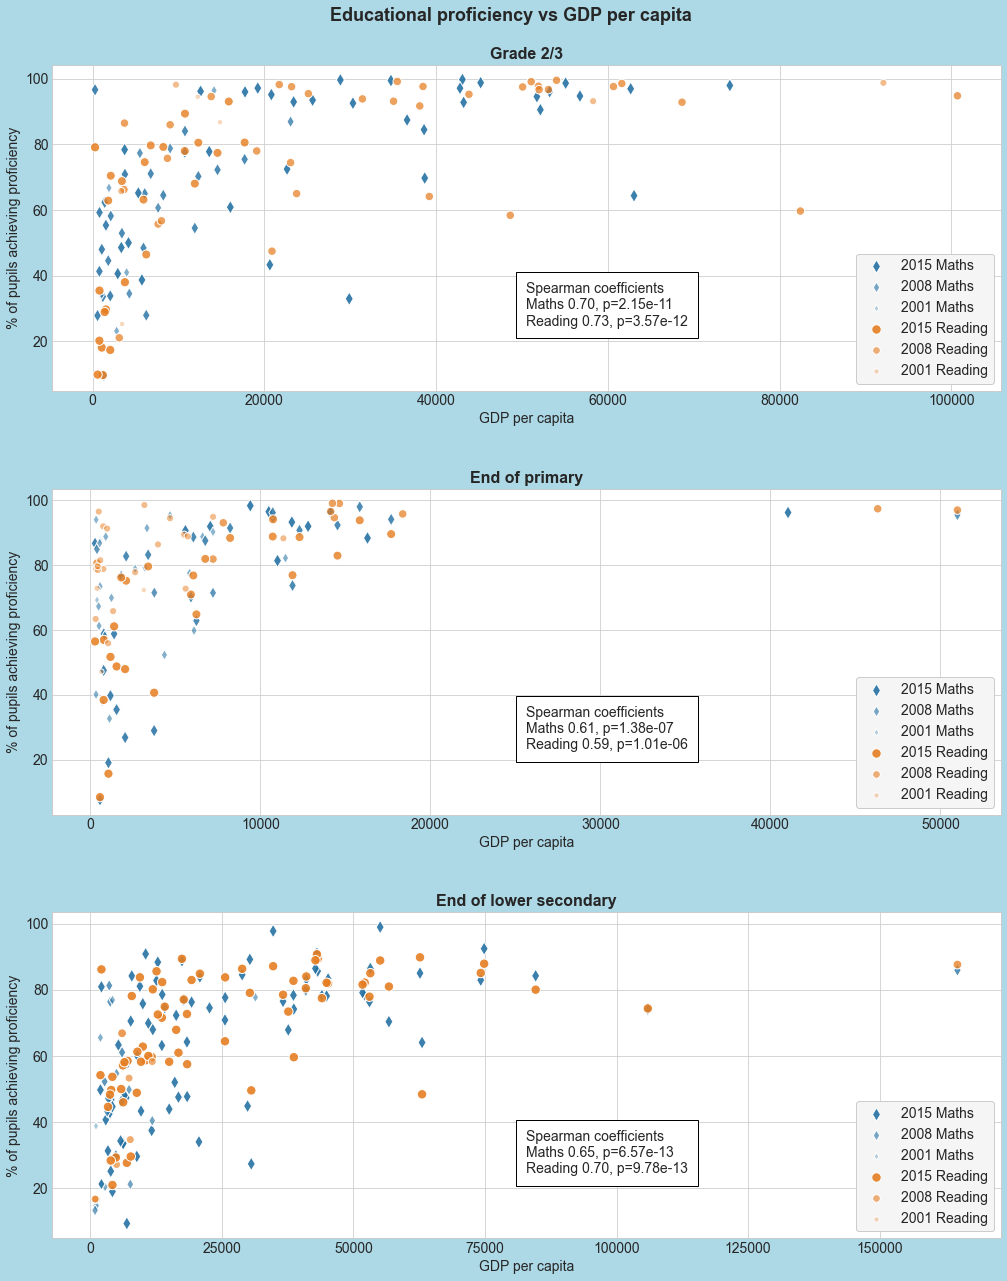

In [45]:
# Create 3 plots in a column.
fig, axs = plt.subplots(3, 1, figsize=(17, 20))
plt_num = 0

# Define our colours
series_colors = {
    'SE_REA_PROF' : [230 / 255, 126 / 255, 34 / 255], # Orange
    'SE_MAT_PROF' : [36 / 255, 113 / 255, 163 / 255], # Blue
}

# Define series markers as circles and thin diamonds.
series_markers = {'SE_REA_PROF' : 'o', 'SE_MAT_PROF' : 'd'}

for edu_level in edu_levels:
    
    spearman_labels = ['Spearman coefficients']
    
    axs[plt_num].set_xlabel('GDP per capita', fontsize=14)
    axs[plt_num].set_ylabel('% of pupils achieving proficiency', fontsize=14)
    axs[plt_num].tick_params(axis='both', labelsize=14)

    for series_code in chart_series_codes:
        
        chart_data = prof_vs_gdp_data.loc[
            (prof_vs_gdp_data['seriescode'] == series_code) &
            (prof_vs_gdp_data['education_level'] == edu_level)
        ]
        
        alphas = convert_year_to_alpha(
            chart_data.index.get_level_values(1).to_numpy(),
            min_year,
            max_year
        )

        axs[plt_num].scatter(
            chart_data['GDP per capita'],
            chart_data['value'],
            edgecolors = 'w',
            c = rgb_to_rgba(series_colors[series_code], alphas),
            s = alphas * marker_alpha_scaling,
            marker = series_markers[series_code]
        )
    
        # Add blank series that will define the legend
        for i in range(len(legend_years)):
            rgba = series_colors[series_code].copy()
            rgba.append(legend_alphas[i])
            axs[plt_num].scatter(
                [], [],
                edgecolors = 'w',
                c = [rgba],
                s = legend_alphas[i] * marker_alpha_scaling,
                marker = series_markers[series_code],
                label = f"{str(legend_years[i])} {series_labels[series_code]}"
            )
            
        # Calculate Spearman coefficient and p value
        spearman = chart_data.loc[:, ['GDP per capita', 'value']].corr('spearman').at['GDP per capita', 'value']
        if not np.isnan(spearman):
            pval = chart_data.loc[:, ['GDP per capita', 'value']].corr(spearmanr_pval).at['GDP per capita', 'value']
            spearman_labels.append(f"{series_labels[series_code]} {spearman:.2f}, p={pval:.2e}")
        
    axs[plt_num].set_title(
        edu_level_labels[edu_level],
        fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
    )
    
    axs[plt_num].legend(loc='lower right', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
    
    axs[plt_num].text(
        0.5, 0.2,
        "\n".join(spearman_labels),
        transform=axs[plt_num].transAxes,
        fontsize=14,
        bbox={
            'facecolor' : 'white',
            'pad' : 10
        }
    )
        
    plt_num += 1
    
fig.set_facecolor('lightblue')
plt.subplots_adjust(hspace=0.3, top=0.94)
fig.suptitle('Educational proficiency vs GDP per capita', fontsize=18, fontweight='bold')
plt.show()

# Uncomment for a copy to display in results
# fig.savefig(fname='images/result1.png', bbox_inches='tight')

Montrons aussi par région, cette fois-ci en divisant en "reading" et "maths", et sans indiquer l'année par taille et transparence.

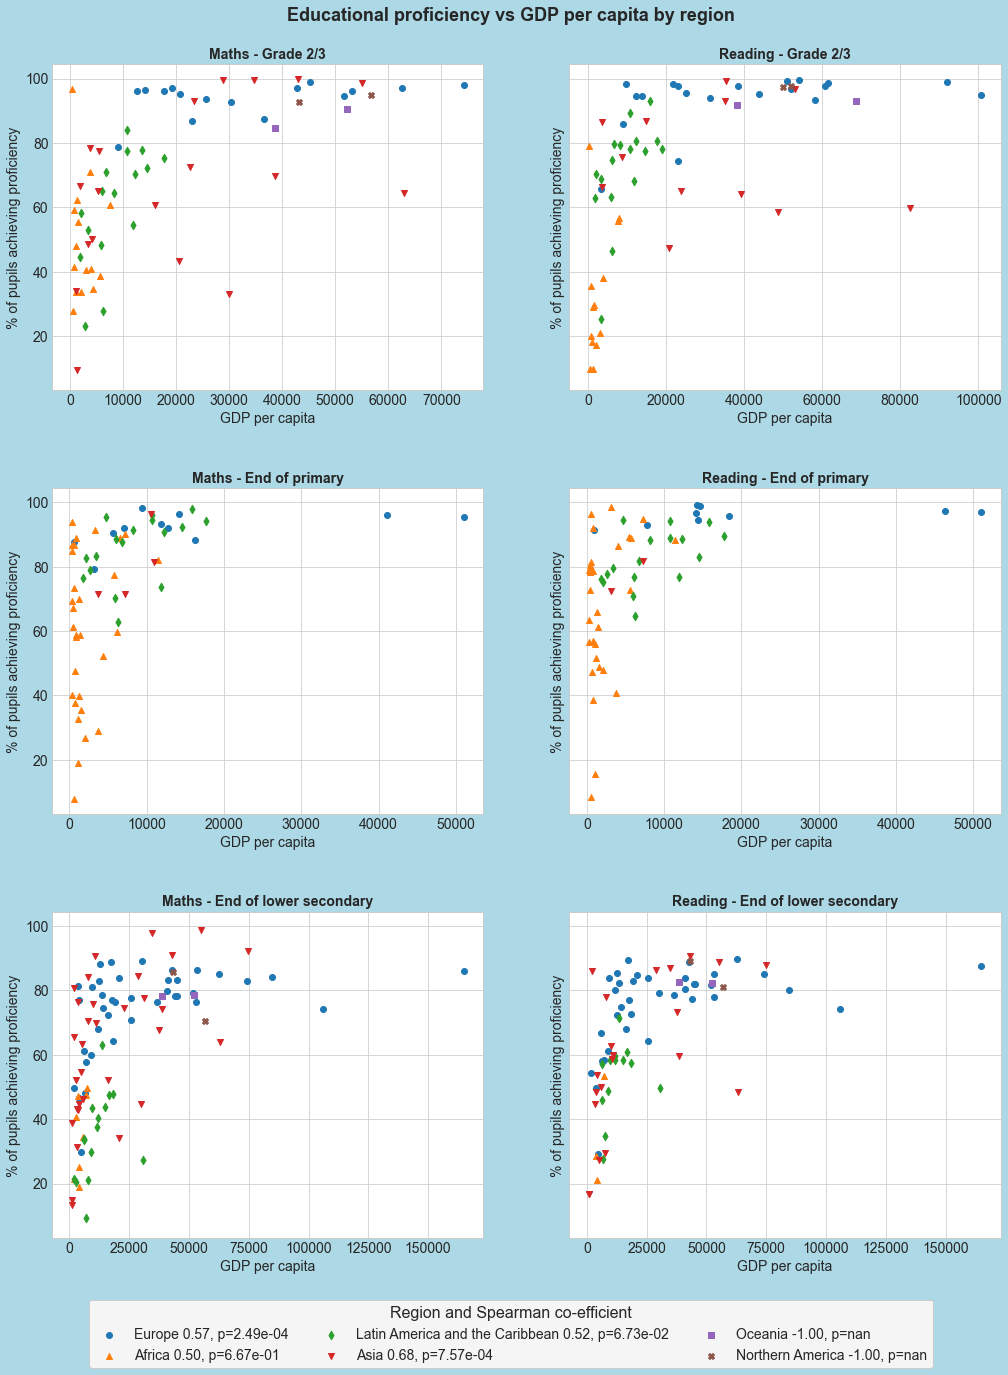

In [46]:
region_markers = ["o", "^", "d", "v", "s", "X"]

# Create a 3 row by 2 col layout of plots
fig, axs = plt.subplots(3, 2, figsize=(17, 20), sharey=True)

plt_col = 0
for series_code in chart_series_codes:
    
    plt_row = 0
    
    for edu_level in edu_levels:
        marker_index = 0
        axs[plt_row, plt_col].set_xlabel('GDP per capita', fontsize=14)
        axs[plt_row, plt_col].set_ylabel('% of pupils achieving proficiency', fontsize=14)
        axs[plt_row, plt_col].tick_params(axis='both', labelsize=14)

        for region in prof_vs_gdp_data['Region Name'].unique():
        
            chart_data = prof_vs_gdp_data.loc[
                (prof_vs_gdp_data['seriescode'] == series_code) &
                (prof_vs_gdp_data['education_level'] == edu_level) &
                (prof_vs_gdp_data['Region Name'] == region)
            ]
            
            label = region
            spearman = chart_data.loc[:, ['GDP per capita', 'value']].corr('spearman').at['GDP per capita', 'value']
            if not np.isnan(spearman):
                pval = chart_data.loc[:, ['GDP per capita', 'value']].corr(spearmanr_pval).at['GDP per capita', 'value']
                label = f"{region} {spearman:.2f}, p={pval:.2e}"
            
            axs[plt_row, plt_col].scatter(
                chart_data['GDP per capita'],
                chart_data['value'],
                marker = region_markers[marker_index],
                label = label
            )

            marker_index += 1
            
        axs[plt_row, plt_col].set_title(
            f"{series_labels[series_code]} - {edu_level_labels[edu_level]}",
            fontdict = {'fontsize' : 14, 'fontweight' : 'bold'}
        )
        plt_row += 1
        
    plt_col += 1

# Convert all legend labels into a dictionary so as to remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='lower center',
    bbox_to_anchor=(0.5, 0.03),
    bbox_transform=fig.transFigure,
    ncol=ceil(len(labels) / 2),
    frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14,
    title="Region and Spearman co-efficient",
    title_fontsize=16
)

fig.set_facecolor('lightblue')
fig.suptitle('Educational proficiency vs GDP per capita by region', fontsize=18, fontweight='bold')
plt.subplots_adjust(hspace=0.3, top=0.94)
plt.show()

# Uncomment for a copy to display in results
# fig.savefig(fname='images/result2.png', bbox_inches='tight')